In [1]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt




''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

def universal_func(So=2000, Fo=50, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization
        
        RH1 = 0.9 #Relative Humidity
        RH2 = 0.8 
        RH3 = 0.3
        
        
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        ws_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        w_1 = RH1 * ws_1
        q1 = w_1/(1+w_1)
        q1_s = ws_1/(1+ws_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport
        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
    
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        def tau(T,Tft):
            tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
            return tau
            
        #epsilon_2 = 1/(1+tau(T2,273))
        #epsilon_3 = 1/(1+tau(T3,273))
        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux = epsilon_2*sigma*T2**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night,Flux)
        
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations,p_guess,full_output=True)
    if ier==1:
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux = equations((T1, T2, T3, T4, Fa, Fc))
    if debug==False:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night)
    else:
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,info,ier,msg)

In [2]:
universal_func(So=2000, assumption='WBG',debug=True,\
    p_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153))

We have a solution:  (286.899893243019, 263.8536694690705, 264.08994300862037, 262.43094138678606, 223.2705955704536, 277.4601485506062)


(286.899893243019,
 263.8536694690705,
 264.08994300862037,
 262.43094138678606,
 223.2705955704536,
 277.4601485506062,
 0.4503419964762378,
 0.009113107386611311,
 0.0026121628752178686,
 0.0009994185533460716,
 0.4998112167933764,
 0.9266243304048701,
 0.6319065943600055,
 226.91818763492995,
 273.27059555370863,
 {'nfev': 25,
  'fjac': array([[-1.92806429e-03,  1.92687483e-03,  2.03565255e-04,
          -1.08574044e-04,  1.72456972e-07,  9.99996258e-01],
         [ 1.15836471e-01, -6.09362869e-01, -6.03021090e-01,
           3.66379970e-01,  3.42618819e-01,  1.55998639e-03],
         [ 1.07263789e-01, -5.64264170e-01,  5.16096151e-01,
          -4.95241409e-01,  3.98095273e-01,  1.13518390e-03],
         [ 5.29352867e-03, -2.78394161e-02, -5.82140309e-01,
          -7.73629974e-01, -2.48608646e-01,  9.83999823e-05],
         [ 1.58785528e-01,  5.54561731e-01, -1.70370529e-01,
          -1.43234822e-01,  7.85942466e-01, -7.43430722e-04],
         [-9.74593150e-01, -4.43326164e-02, -

In [8]:
sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
so = np.linspace(1000,3000,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
        q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], \
        OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx], info,ier,msg = universal_func(So = s, assumption  = 'WBG',p_guess=initial_guess,debug=True)
    #if ier!=1:
    #    print(ier,msg)
    #    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    #        q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], \
    #        OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx], info,ier,msg = universal_func(So = s, assumption  = 'WBG',debug=True)
    #    if ier!=1: print('Cannot find a solution...')
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx])
    #print('end of loop ',initial_guess)
LR_atm_WBG = epsilon_2_arr_WBG*sigma*(T2_arr_WBG**4)

0 1000.0
We have a solution:  (267.15236056069625, 236.46569476982492, 236.48553944317203, 188.48835757798247, 30.76282045676923, 49.4082038869283)
1 1020.2020202020202
We have a solution:  (267.9780305139093, 237.4737223317079, 237.4956835817632, 190.09762248490983, 34.18766885852232, 53.02367798761082)
2 1040.4040404040404
We have a solution:  (268.75049788138705, 238.42890990574256, 238.45306578426144, 191.7269812492287, 37.71636563144394, 56.810845902195744)
3 1060.6060606060605
We have a solution:  (269.47581032745035, 239.33659998404968, 239.36302579301332, 193.37075222710322, 41.337683756945616, 60.75154786185686)
4 1080.8080808080808
We have a solution:  (270.15912105137846, 240.20140473146338, 240.23017332914313, 195.02394933970803, 45.04103953672901, 64.82924773430892)
5 1101.010101010101
We have a solution:  (270.8048621822194, 241.02734752643497, 241.05852965839415, 196.68225647988578, 48.816559979480495, 69.02886267672646)
6 1121.2121212121212
We have a solution:  (271.416

In [9]:
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    print(idx,s)
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
        q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx], \
        OLR_day_arr_WTG[idx], OLR_night_arr_WTG[idx],info,ier,msg = universal_func(So = s, assumption  = 'WTG',debug=True,p_guess=initial_guess)
    #if ier!=1: print(ier,msg)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx])
LR_atm_WTG = epsilon_2_arr_WTG*sigma*(T2_arr_WTG**4)

0 1000.0
We have a solution:  (267.3374961547689, 236.44180645698796, 236.44180645698796, 188.4212041726929, 30.621219602775263, 48.84390533259132)
1 1020.2020202020202
We have a solution:  (268.1755399450254, 237.4535558564654, 237.4535558564654, 190.02826602349938, 34.038821742590486, 52.41666462402291)
2 1040.4040404040404
We have a solution:  (268.9599869609351, 238.41267420246564, 238.41267420246564, 191.6561721476605, 37.561748562236566, 56.162842797742634)
3 1060.6060606060605
We have a solution:  (269.6968900567556, 239.32446860486218, 239.32446860486218, 193.29921173862445, 41.1788047240474, 60.0644592327131)
4 1080.8080808080808
We have a solution:  (270.39141022730973, 240.19351942223417, 240.19351942223417, 194.95235415228473, 44.87939835932223, 64.10510022098943)
5 1101.010101010101
We have a solution:  (271.04798977290534, 241.02382213519078, 241.02382213519078, 196.6112282633772, 48.65361556042475, 68.26975336741678)
6 1121.2121212121212
We have a solution:  (271.6704827

(4, 100)


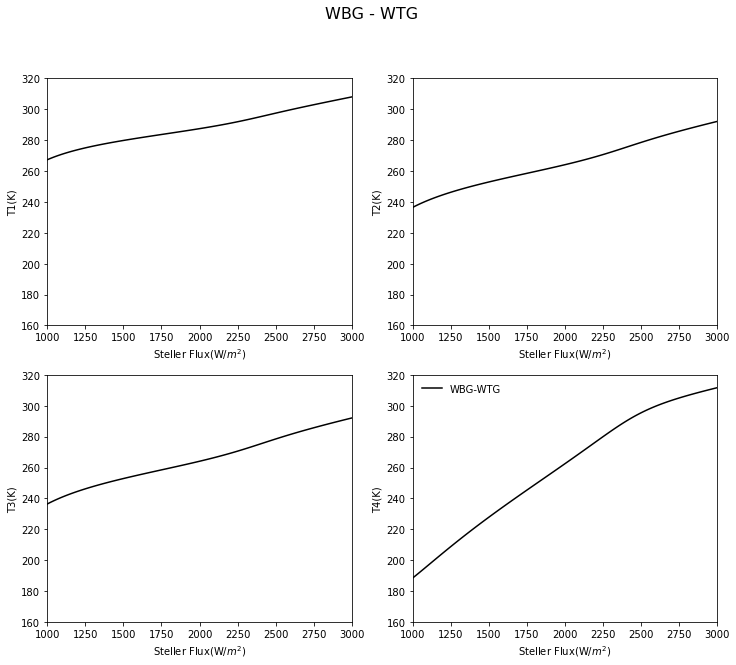

In [10]:

def plot_diff(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    #plt.style.use('ggplot')
    #plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
#plt.rcParams['figure.constrained_layout.use']=True
plot_diff(so)

(4, 100)


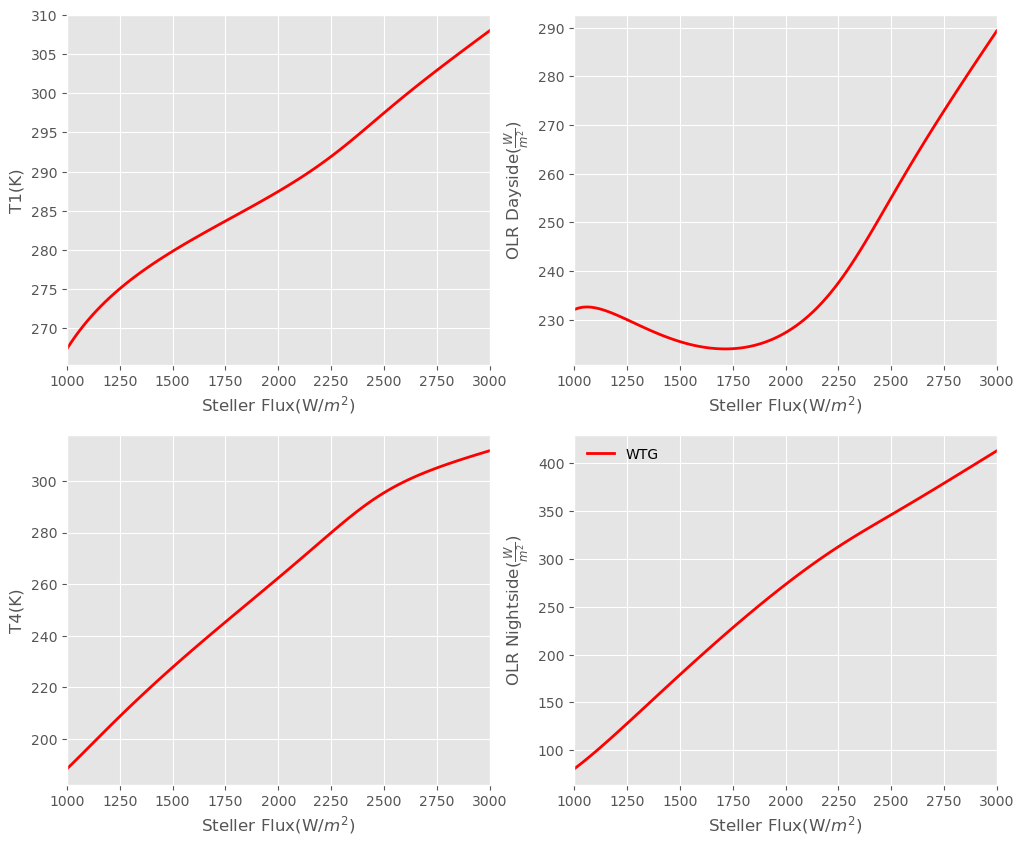

In [32]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG'], ['r'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            #arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
            #arr_list = [T2_arr_WBG, epsilon_2_arr_WBG,OLR_day_arr_WBG,LR_atm_WBG]
            arr_list = [T1_arr_WBG,OLR_day_arr_WBG,T4_arr_WBG,OLR_night_arr_WBG]
            #arr_list = [Fa_arr_WBG, Fc_arr_WBG]
            #arr_list = [epsilon_2_arr_WBG, epsilon_3_arr_WBG]

        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            #arr_list = [Fa_arr_WTG, Fc_arr_WTG]
            #arr_list = [T2_arr_WTG, epsilon_2_arr_WTG,OLR_day_arr_WTG,LR_atm_WTG]
            arr_list = [T1_arr_WTG,OLR_day_arr_WTG,T4_arr_WTG,OLR_night_arr_WTG]
            #arr_list = [epsilon_2_arr_WTG, epsilon_3_arr_WTG]
        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
        #name_list = ['Fa','Fc']
        #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
        #name_list = [r'$\epsilon_2$',r'$\epsilon_3$']
        #unit_list = ['','']
        name_list = ['T1','OLR Dayside','T4',  'OLR Nightside']
        unit_list = ['K',  r'$\frac{W}{m^2}$', 'K',r'$\frac{W}{m^2}$']
        
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  = plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption, linewidth = 2)


            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            plt.xlim(1000,3000)
            #if idx <= 1:
            #    plt.ylim(180,310)
            if idx ==3: 
                plt.legend(frameon = False, loc = 'best')
                
    #plt.style.use('ggplot')
    #plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig
plt.style.use('ggplot')
#plt.rcParams['figure.constrained_layout.use']=True
plot_across_so(so)

(4, 100)


NameError: name 'xlab' is not defined

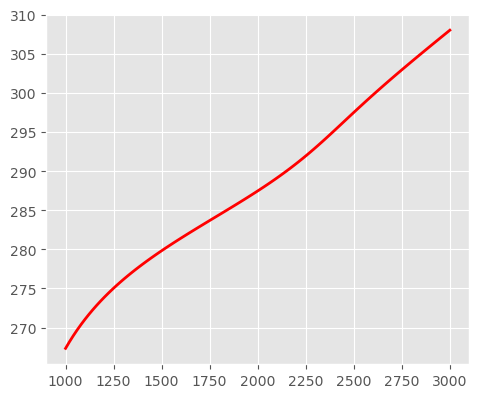

In [31]:
fig = plt.figure(figsize = (12,10))
for i_assump, (assumption, my_color) in enumerate(zip(['WTG'], ['r'])):
    if assumption == 'WBG':
        #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
        #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
        #arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
        #arr_list = [T2_arr_WBG, epsilon_2_arr_WBG,OLR_day_arr_WBG,LR_atm_WBG]
        arr_list = [T1_arr_WBG,OLR_day_arr_WBG,T4_arr_WBG,OLR_night_arr_WBG]
        #arr_list = [Fa_arr_WBG, Fc_arr_WBG]
        #arr_list = [epsilon_2_arr_WBG, epsilon_3_arr_WBG]

    elif assumption == 'WTG':
        #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
        #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
        #arr_list = [Fa_arr_WTG, Fc_arr_WTG]
        #arr_list = [T2_arr_WTG, epsilon_2_arr_WTG,OLR_day_arr_WTG,LR_atm_WTG]
        arr_list = [T1_arr_WTG,OLR_day_arr_WTG,T4_arr_WTG,OLR_night_arr_WTG]
        #arr_list = [epsilon_2_arr_WTG, epsilon_3_arr_WTG]

    nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
    #name_list = ['Fa','Fc']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    #name_list = [r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = ['','']
    name_list = ['T1','OLR Dayside', 'T4', 'OLR Nightside']
    unit_list = ['K',  r'$\frac{W}{m^2}$','K', r'$\frac{W}{m^2}$']


    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  = plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = my_color, markersize = 9, label = assumption, linewidth = 2)


        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        #if idx <= 1:
        #    plt.ylim(180,310)
        if idx ==3: 
            plt.legend(frameon = False, loc = 'best')

#plt.style.use('ggplot')
#plt.savefig("WTG_WBG_compare_T1-T4.png")
plt.close()

### plotting

(2, 100)
(2, 100)


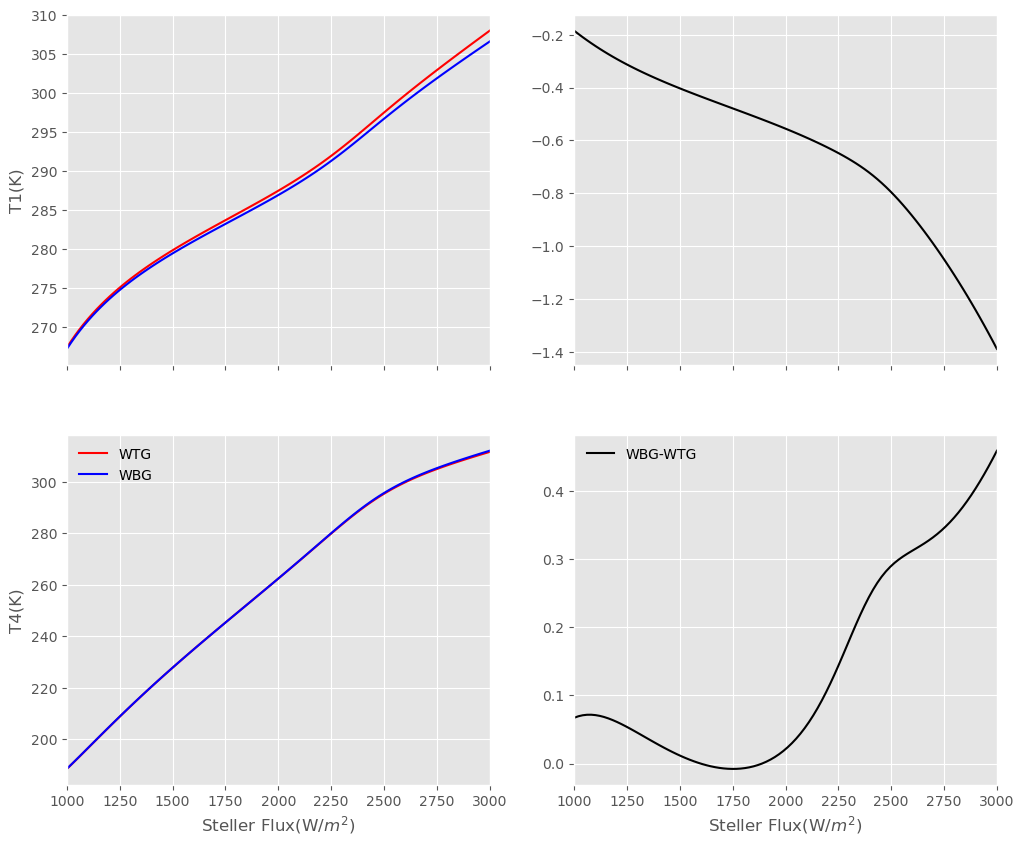

In [30]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
   
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    #arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list_WTG = [OLR_day_arr_WTG, OLR_night_arr_WTG]
    #arr_list_WBG  = [OLR_day_arr_WBG, OLR_night_arr_WBG]
    arr_list_WBG = [T1_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fc_arr_WBG, Fa_arr_WBG]
    #arr_list_WTG = [Fc_arr_WTG, Fa_arr_WTG]
    
    name_list = ['T1','T4']
    unit_list = ['K','K']
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    #name_list = ['OLR_day', 'OLR_night']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    #name_list = ['Fc','Fa']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (12,10))
    ax = axs[0][0]
    
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG
        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            
            plt.xlim(1000,3000)
            #plt.ylim(50,350)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        #plt.ylim(50,350)
        if idx == nele -1: 
            plt.legend(frameon = False)
            ax.set_xlabel(xlab +'('+ xunit +')')
            #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            
    #axs[0][0].set_ylim(50,350)
    #plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
        
        
    

    return fig
plt.style.use('ggplot')
plot_8panels(so)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


70
70
73
73


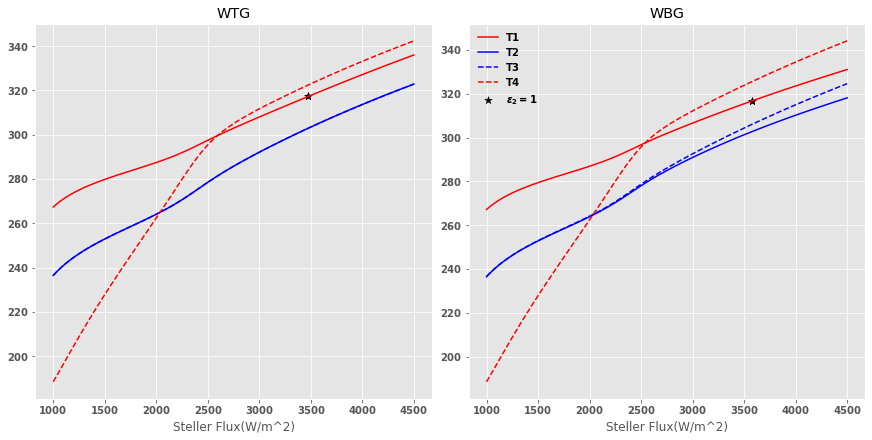

In [9]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(so, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(so, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(so, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(so, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Steller Flux' +'(W/m^2)')
    #plt.xlim(1000,3000)
    #plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)


Text(0, 0.5, '$\\epsilon \\sigma T^4$')

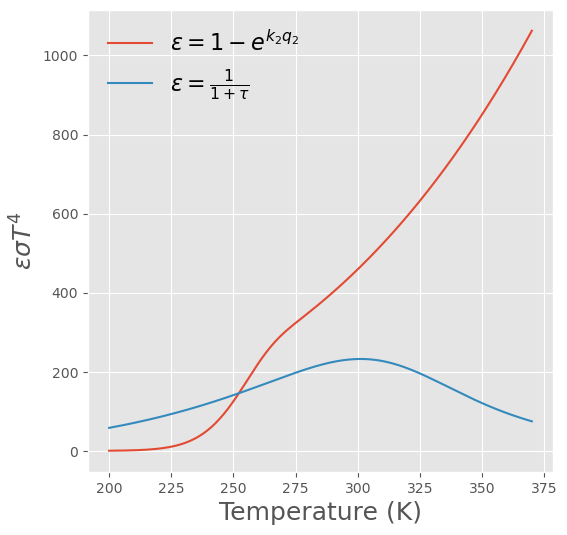

In [35]:

def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau


def epsilon_orig(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
    k2 = 1000
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    #q2_s = ws_2/(1+ws_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2        


T = np.linspace(200,370,200)
epsilon_2_tau = 1/(1+tau(T,273))
epsilon_2 = epsilon_orig(T)

Lr_atm_gh = epsilon_2_tau*sigma*T**4
Lr_atm = epsilon_2*sigma*T**4

plt.rcParams['figure.constrained_layout.use']=False
fig = plt.figure(figsize =(6,6))
plt.style.use('ggplot')
#plt.style.use('default')

plt.plot(T, Lr_atm, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
plt.legend(loc = 'best',fontsize=16, frameon = False)
plt.xlabel('Temperature (K)', fontsize = 18)
plt.ylabel(r'$\epsilon \sigma T^4$', fontsize = 18)
